<a href="https://colab.research.google.com/github/pnandini-sdu/AAI-511-Final-Project/blob/main/NN%26DL_Final_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretty_midi

In [ ]:
# Importing all necessary libraries
import os
import pretty_midi
import numpy as np
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Mounting content from my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data set zip fle path from my google drive
zip_path = "/content/drive/My Drive/midiclassics.zip"
extract_path = "/content/drive/My Drive/extracted_dataset"

# Extract all composers midi files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/drive/My Drive/extracted_dataset


In [ ]:
# Define constants
dataset_path = extract_path
pitch_range = (24, 108)
roll_length = 128
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
composers_to_idx = {name: i for i, name in enumerate(composers)}

In [ ]:
# Data Pre-processing
def midi_to_roll(filepath, fs=16, transpose=0):
    try:
        midi = pretty_midi.PrettyMIDI(filepath)
        roll = midi.get_piano_roll(fs=fs)
        roll = np.roll(roll, transpose, axis=0)
        roll = roll[pitch_range[0]:pitch_range[1], :]
        roll = (roll > 0).astype(np.uint8)
        return roll
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

def extract_segments(roll, segment_length=roll_length):
    segments = []
    for start in range(0, roll.shape[1] - segment_length, segment_length):
        segment = roll[:, start:start + segment_length]
        if segment.shape[1] == segment_length:
            segments.append(segment)
    return segments

def get_all_mid_files(directory):
    mid_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                mid_files.append(os.path.join(root, file))
    return mid_files

def load_and_process_data():
    X = []
    y = []

    for composer in composers:
        composer_dir = os.path.join(dataset_path, composer)
        mid_files = get_all_mid_files(composer_dir)

        for filepath in mid_files:
            for transpose in range(-3, 4):  # Data augmentation
                roll = midi_to_roll(filepath, transpose=transpose)
                if roll is not None:
                    segments = extract_segments(roll)
                    X.extend(segments)
                    y.extend([composers_to_idx[composer]] * len(segments))

    return np.array(X), np.array(y)

# Load data
X, y = load_and_process_data()
print(f"Data shape: {X.shape}, Labels: {y.shape}")

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing /content/drive/My Drive/extracted_dataset/Mozart/Pia

In [ ]:
# Count Tokens for each Composer to understand the dataset imbalance
def count_tokens_in_midi(filepath):
    """Count note tokens in a single MIDI file."""
    try:
        midi = pretty_midi.PrettyMIDI(filepath)
        token_count = 0
        for instrument in midi.instruments:
            if not instrument.is_drum:
                token_count += len(instrument.notes)
        return token_count
    except Exception as e:
        print(f"Failed to process {filepath}: {e}")
        return 0

def get_all_mid_files_recursive(base_dir):     # Recursively collect all .mid and .MID files in a directory.
    mid_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                mid_files.append(os.path.join(root, file))
    return mid_files

def token_count_by_composer(dataset_path, composers):
    token_counts = defaultdict(int)   # Compute total token count for each composer.

    for composer in composers:
        composer_dir = os.path.join(dataset_path, composer)
        midi_files = get_all_mid_files_recursive(composer_dir)

        for file_path in midi_files:
            token_counts[composer] += count_tokens_in_midi(file_path)

        print(f"{composer}: {len(midi_files)} MIDI files scanned.")

    return token_counts

# Find token count by composer
token_counts = token_count_by_composer(dataset_path, composers)

print("Total Token Counts per Composer:")
for composer, count in token_counts.items():
    print(f"{composer}: {count:,} tokens")


Bach: 1024 MIDI files scanned.
Failed to process /content/drive/My Drive/extracted_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Beethoven: 213 MIDI files scanned.
Chopin: 136 MIDI files scanned.
Failed to process /content/drive/My Drive/extracted_dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Mozart: 257 MIDI files scanned.
Total Token Counts per Composer:
Bach: 1,775,212 tokens
Beethoven: 1,603,865 tokens
Chopin: 319,703 tokens
Mozart: 1,378,190 tokens


In [ ]:
# Balanced Segment Extraction
def midi_to_roll(filepath, fs=16, transpose=0):
    try:
        midi = pretty_midi.PrettyMIDI(filepath)
        roll = midi.get_piano_roll(fs=fs)
        roll = np.roll(roll, transpose, axis=0)
        roll = roll[pitch_range[0]:pitch_range[1], :]
        return (roll > 0).astype(np.uint8)
    except:
        return None

def extract_segments(roll, segment_length=roll_length):
    segments = []
    for start in range(0, roll.shape[1] - segment_length, segment_length):
        segment = roll[:, start:start + segment_length]
        if segment.shape[1] == segment_length:
            segments.append(segment)
    return segments

def balanced_segment_loader(max_segments_per_class=5000):
    X, y = [], []

    for composer in composers:
        print(f"\nProcessing {composer}")
        composer_dir = os.path.join(dataset_path, composer)
        midi_files = get_all_mid_files_recursive(composer_dir)
        composer_segments = []

        for filepath in midi_files:
            for transpose in range(-3, 4):  # Data augmentation
                roll = midi_to_roll(filepath, transpose=transpose)
                if roll is not None:
                    segments = extract_segments(roll)
                    composer_segments.extend(segments)

        print(f"  Total segments before trimming: {len(composer_segments)}")
        random.shuffle(composer_segments)
        selected = composer_segments[:max_segments_per_class]

        X.extend(selected)
        y.extend([composers_to_idx[composer]] * len(selected))
        print(f"  Selected {len(selected)} segments")

    return np.array(X), np.array(y)

# Load balanced data
X, y = balanced_segment_loader(max_segments_per_class=5000)
print(f"\n Final dataset shape: {X.shape}, Labels: {y.shape}")



Processing Bach
  Total segments before trimming: 135135
  Selected 5000 segments

Processing Beethoven
  Total segments before trimming: 89327
  Selected 5000 segments

Processing Chopin
  Total segments before trimming: 25788
  Selected 5000 segments

Processing Mozart
  Total segments before trimming: 88536
  Selected 5000 segments

 Final dataset shape: (20000, 84, 128), Labels: (20000,)


In [ ]:
# Normalize
X = X.astype(np.float32)
X = X / 1.0
y_cat = keras.utils.to_categorical(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


# Build CNN Model
def build_cnn_model(input_shape, num_classes):
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Reshape((*input_shape, 1)),  # Add channel dimension
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Train
model = build_cnn_model(X.shape[1:], len(composers))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4294 - loss: 1.2643 - val_accuracy: 0.5919 - val_loss: 1.0073
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6302 - loss: 0.9234 - val_accuracy: 0.5913 - val_loss: 0.9667
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7216 - loss: 0.7088 - val_accuracy: 0.6375 - val_loss: 0.9042
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8215 - loss: 0.4851 - val_accuracy: 0.6334 - val_loss: 1.0052
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8956 - loss: 0.3029 - val_accuracy: 0.6244 - val_loss: 1.1121
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9324 - loss: 0.1951 - val_accuracy: 0.6209 - val_loss: 1.3182
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9558 - loss: 0.1323 - val_accuracy: 0.6228 - val_loss: 1.3915
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9687 - loss: 0.0978 - val_accuracy: 0

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.6085
Classification Report:
              precision    recall  f1-score   support

        Bach       0.77      0.59      0.67       995
   Beethoven       0.54      0.49      0.51      1024
      Chopin       0.70      0.70      0.70      1004
      Mozart       0.49      0.66      0.56       977

    accuracy                           0.61      4000
   macro avg       0.63      0.61      0.61      4000
weighted avg       0.63      0.61      0.61      4000



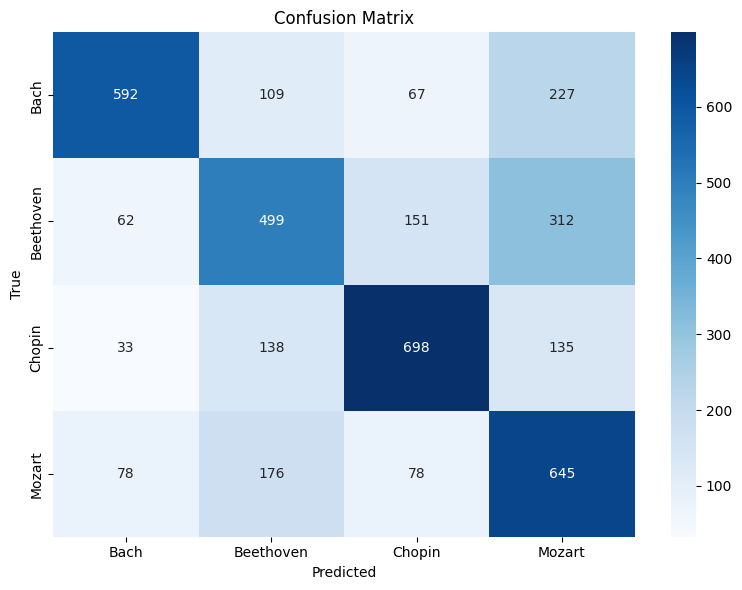

In [ ]:
# 1. Predict on test set
y_pred = model.predict(X_test)
y_pred_composers = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. Accuracy Score
test_accuracy = accuracy_score(y_true, y_pred_composers)
print(f"Test Accuracy: {test_accuracy:.4f}")

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_composers, target_names=composers))

# 4. Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_composers)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=composers, yticklabels=composers, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

